In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import classification_report, mean_squared_error


In [3]:
# Replace filename with the actual Kaggle CSV file you uploaded
df = pd.read_csv("./Data/Nepal_buildings_w.csv")

print("Rows:", len(df))
df.head()

Rows: 762106


,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,damage_grade,technical_solution_proposed,superstructure,damage_score,damage_class
0,1.201010e+11,12,1207,120703,1,1,9,288,9,9,...,Mud,Not applicable,Not attached,Rectangular,Damaged-Used in risk,3.0,Major repair,has_superstructure_mud_mortar_stone,6.0,medium
1,1.201010e+11,12,1207,120703,1,1,15,364,9,9,...,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,3.0,Reconstruction,has_superstructure_mud_mortar_stone,6.0,medium
2,1.201010e+11,12,1207,120703,1,1,20,384,9,9,...,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,2.0,Minor repair,has_superstructure_mud_mortar_stone,4.0,medium
3,1.201010e+11,12,1207,120703,1,1,20,312,9,9,...,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,2.0,Minor repair,has_superstructure_mud_mortar_stone,4.0,medium
4,1.201010e+11,12,1207,120703,1,1,30,308,9,9,...,Mud,Not applicable,Not attached,Rectangular,Damaged-Repaired and used,1.0,Minor repair,has_superstructure_mud_mortar_stone,2.0,low


In [4]:
# Dataset must contain damage_grade 0–5 or similar numeric labels
if "damage_grade" not in df.columns:
    raise Exception("Dataset must contain 'damage_grade' column.")


# Convert 0–5 → 0–10
df["damage_score"] = (df["damage_grade"] / df["damage_grade"].max()) * 10

# Categorize
df["damage_class"] = pd.cut(
    df["damage_score"],
    bins=[-0.1, 3.3, 6.6, 10],
    labels=["low", "medium", "high"]
)

df["damage_class"].value_counts()

damage_class
high      459609
medium    223670
low        78815
Name: count, dtype: int64

In [5]:
print(df["damage_grade"].dtype)          # Should be int64 or float64
print(df["damage_grade"].unique())       # See all distinct values
print(df["damage_grade"].apply(type).value_counts())  # Count types in the column

float64
[ 3.  2.  1.  5.  4. nan]
damage_grade
<class 'float'>    762106
Name: count, dtype: int64


In [6]:
# Feature extraction (these columns exist in most Nepal datasets)
features = {
    "floors": "count_floors_pre_eq",
    "age_building": "age_building",
    "plinth_area_sq_ft": "plinth_area_sq_ft",
    "material": "foundation_type",
    "roof": "roof_type"
}

for key, col in features.items():
    if col not in df.columns:
        raise Exception(f"Required column missing: {col}")

X = df[list(features.values())].copy()
X.columns = list(features.keys())  # rename cleanly

y_class = df["damage_class"]
y_score = df["damage_score"]

X.head()

,floors,age_building,plinth_area_sq_ft,material,roof
0,1,9,288,Other,Bamboo/Timber-Light roof
1,1,15,364,Other,Bamboo/Timber-Light roof
2,1,20,384,Other,Bamboo/Timber-Light roof
3,1,20,312,Other,Bamboo/Timber-Light roof
4,1,30,308,Other,Bamboo/Timber-Light roof


In [ ]:
numeric = ["floors", "age", "area"]
categorical = ["material", "roof"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)


In [8]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [9]:
df = pd.read_csv(r"C:\Users\balaj\vscode\ML\earthquake\Earthquake-Damage-Prediction\Data\Nepal_buildings_w.csv")

In [10]:
df["damage_score"] = (df["damage_grade"] / 5) * 10

df["damage_class"] = pd.cut(
    df["damage_score"],
    bins=[-0.1, 3.3, 6.6, 10],
    labels=["low", "medium", "high"]
)

In [48]:
# df.to_csv(r"D:\Earthquake\Data\Nepal_buildings_w.csv", index=False)


In [11]:
# Ensure label columns have values (drop rows where labels are missing)
mask = y_class.notna() & y_score.notna()
if mask.sum() == 0:
    raise Exception("No labeled rows found in 'damage_class' / 'damage_score'. Check 'damage_grade' column in the source CSV.")

# Rename X columns to match the preprocessor numeric names ('age' and 'area')
# (preprocessor expects numeric columns: ['floors', 'age', 'area'])
X_prepared = X.rename(columns={"age_building": "age", "plinth_area_sq_ft": "area"})

# Filter to only rows with labels
X_clean = X_prepared[mask].reset_index(drop=True)
y_class_clean = y_class[mask].reset_index(drop=True)
y_score_clean = y_score[mask].reset_index(drop=True)

# Split
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X_clean, y_class_clean, y_score_clean, test_size=0.2, random_state=42, stratify=y_class_clean
)

In [13]:
import os

In [14]:
os.cpu_count()

12

In [17]:
knn = Pipeline([
    ("pre", preprocessor),
    ("model", KNeighborsClassifier(n_neighbors=7))
])

knn.fit(X_train, y_class_train)
y_pred_knn = knn.predict(X_test)

print("=== KNN Classification Report ===")
print(classification_report(y_class_test, y_pred_knn))

=== KNN Classification Report ===
              precision    recall  f1-score   support

        high       0.69      0.86      0.77     91922
         low       0.50      0.38      0.43     15763
      medium       0.40      0.23      0.29     44734

    accuracy                           0.63    152419
   macro avg       0.53      0.49      0.50    152419
weighted avg       0.58      0.63      0.59    152419



In [20]:
rf = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42,n_jobs=-1))
])

rf.fit(X_train, y_class_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest Classification Report ===")
print(classification_report(y_class_test, y_pred_rf))

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

        high       0.69      0.86      0.77     91922
         low       0.48      0.36      0.41     15763
      medium       0.40      0.23      0.29     44734

    accuracy                           0.63    152419
   macro avg       0.52      0.49      0.49    152419
weighted avg       0.58      0.63      0.59    152419



In [19]:
dt = Pipeline([
    ("pre", preprocessor),
    ("model", DecisionTreeClassifier(max_depth=10, random_state=42))
])

dt.fit(X_train, y_class_train)
y_pred_dt = dt.predict(X_test)

print("=== Decision Tree Classification Report ===")
print(classification_report(y_class_test, y_pred_dt))

=== Decision Tree Classification Report ===
              precision    recall  f1-score   support

        high       0.69      0.95      0.80     91922
         low       0.58      0.37      0.45     15763
      medium       0.49      0.17      0.25     44734

    accuracy                           0.66    152419
   macro avg       0.59      0.50      0.50    152419
weighted avg       0.62      0.66      0.60    152419



In [55]:
dt

,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
lr = Pipeline([
    ("pre", preprocessor),
    ("model", LinearRegression())
])

lr.fit(X_train, y_score_train)
y_pred_lr_score = lr.predict(X_test)

print("=== Linear Regression MSE ===")
print(mean_squared_error(y_score_test, y_pred_lr_score))

=== Linear Regression MSE ===
5.374402777667547


In [16]:
def score_to_class(v):
    if v <= 3.3:
        return "low"
    elif v <= 6.6:
        return "medium"
    return "high"

y_pred_lr_class = [score_to_class(v) for v in y_pred_lr_score]

print("=== LR Converted to Classification ===")
print(classification_report(y_class_test, y_pred_lr_class))

=== LR Converted to Classification ===
              precision    recall  f1-score   support

        high       0.69      0.94      0.79     91922
         low       0.60      0.18      0.27     15763
      medium       0.43      0.22      0.29     44734

    accuracy                           0.65    152419
   macro avg       0.57      0.44      0.45    152419
weighted avg       0.60      0.65      0.59    152419



In [23]:
joblib.dump(knn, "KNN.pkl")

joblib.dump(lr, "LinearRegression.pkl")

print("Saved: KNN.pkl, RandomForest.pkl, DecisionTree.pkl, LinearRegression.pkl")

Saved: KNN.pkl, RandomForest.pkl, DecisionTree.pkl, LinearRegression.pkl


In [24]:
sample = pd.DataFrame([{
    "floors": 3,
    "age": 40,
    "area": 150,
    "material": "Mud mortar-Stone/Brick",
    "roof": "Bamboo/Timber-Light roof"
}])

model = joblib.load("KNN.pkl")
print("Predicted:", model.predict(sample)[0])

Predicted: high


In [25]:
rf.named_steps['model'].feature_importances_

array([0.04400488, 0.17355184, 0.54697685, 0.03245555, 0.00872649,
       0.09761398, 0.00196857, 0.02999096, 0.00353703, 0.0035062 ,
       0.05766764])

In [26]:
X_train.shape

(609675, 5)

In [27]:
import time

import numpy as np

start_time = time.time()
importances = rf.named_steps['model'].feature_importances_
# access the fitted RandomForestClassifier inside the pipeline to get its estimators_
std = np.std([tree.feature_importances_ for tree in rf.named_steps['model'].estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.486 seconds


In [28]:
from sklearn.inspection import permutation_importance

start_time = time.time()
# use the classification labels for permutation importance
result = permutation_importance(
    rf, X_test, y_class_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# get feature names from the fitted ColumnTransformer inside the pipeline
# fall back to raw column names if get_feature_names_out isn't available
try:
    feature_names = rf.named_steps['pre'].get_feature_names_out()
except Exception:
    feature_names = X_test.columns.tolist()



Elapsed time to compute the importances: 389.971 seconds


In [45]:
feature_names = X_test.columns.to_list()
feature_names

['floors', 'age', 'area', 'material', 'roof']

In [34]:
result

{'importances_mean': array([0.01398054, 0.01521005, 0.01658914, 0.04923205, 0.02182864]),
 'importances_std': array([0.00055665, 0.00082618, 0.00057099, 0.00067863, 0.00077551]),
 'importances': array([[0.01463728, 0.01331855, 0.01391559, 0.01426987, 0.01296426,
         0.01365971, 0.01444702, 0.01354818, 0.01460448, 0.01444046],
        [0.01498501, 0.0159757 , 0.014283  , 0.01589697, 0.0160085 ,
         0.01523432, 0.01573295, 0.01343008, 0.01465697, 0.01589697],
        [0.01666459, 0.01673676, 0.01627094, 0.01697295, 0.01552956,
         0.01631686, 0.01683517, 0.01639559, 0.01785867, 0.0163103 ],
        [0.04763842, 0.04918022, 0.04839292, 0.04937705, 0.04962636,
         0.04994784, 0.04975758, 0.04979694, 0.04912117, 0.04948202],
        [0.02108661, 0.0208701 , 0.02207074, 0.02139497, 0.02131624,
         0.02214947, 0.02359286, 0.02150651, 0.02265466, 0.02164428]])}

In [36]:
importances_mean = result.importances_mean
importances_std = result.importances_std

In [37]:
print(importances_mean, importances_std)

[0.01398054 0.01521005 0.01658914 0.04923205 0.02182864] [0.00055665 0.00082618 0.00057099 0.00067863 0.00077551]


In [46]:
df_importances = pd.DataFrame({
    "features" : feature_names,
    "importance": importances_mean,
    "std": importances_std
})
df_importances

,features,importance,std
0,floors,0.013981,0.000557
1,age,0.015210,0.000826
2,area,0.016589,0.000571
3,material,0.049232,0.000679
4,roof,0.021829,0.000776


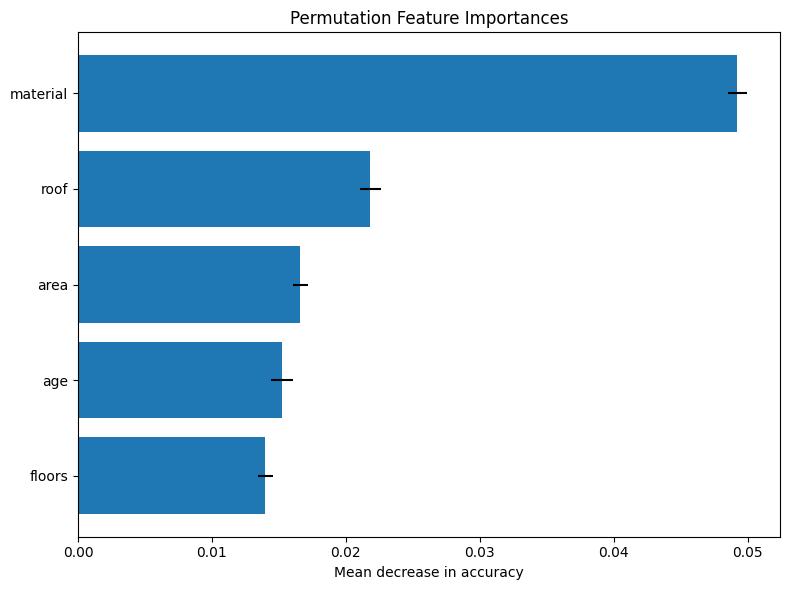

In [48]:
df_importances = df_importances.sort_values("importance", ascending=True)  # optional for nicer plot

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(df_importances["features"], df_importances["importance"], xerr=df_importances["std"])
ax.set_xlabel("Mean decrease in accuracy")
ax.set_title("Permutation Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
#train for only the important featueres
top_features = df_importances['features'].head(3).to_list()

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

rf_top = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_top.fit(X_train_top, y_class_train)

In [53]:
y_pred_top = rf_top.predict(X_test_top)
print(classification_report(y_class_test, y_pred_top))

              precision    recall  f1-score   support

        high       0.65      0.88      0.75     91922
         low       0.45      0.24      0.32     15763
      medium       0.37      0.17      0.23     44734

    accuracy                           0.60    152419
   macro avg       0.49      0.43      0.43    152419
weighted avg       0.55      0.60      0.55    152419



In [55]:
y_pred = rf.predict(X_test)
df_vis = pd.DataFrame({
    "Actual": y_class_test,
    "Predicted": y_pred
})
df_vis

,Actual,Predicted
326956,high,high
157127,high,high
441067,high,medium
677353,high,high
153761,high,high
...,...,...
685218,high,high
601377,low,high
37250,low,high
127218,medium,high


C:\Users\balaj\AppData\Local\Temp\ipykernel_5188\3079251781.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_vis.groupby(["Actual", "Predicted"]).size().unstack().plot(kind="bar", stacked=True)


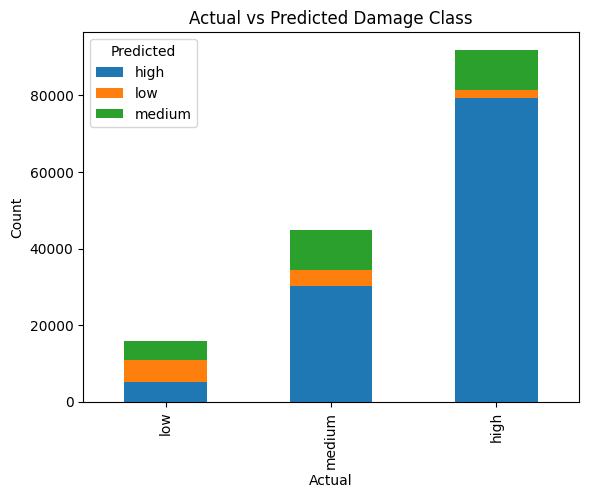

In [ ]:
#actual and prodicted things graph
df_vis.groupby(["Actual", "Predicted"], observed=False).size().unstack().plot(kind="bar", stacked=True)
plt.title("Actual vs Predicted Damage Class")
plt.ylabel("Count")
plt.show()